# Plant Pathology Kaggle
> Creating a top 10 leaderboard submission for the Plant Pathology Kaggle Competition

- toc: true
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Computer Vision, Image Classification, Kaggle]


This post is looking at the [plant pathology kaggle competition](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/) and showing how you could create a top 10 kaggle submission with fastai.  This is the first of a blog series where I will do this with historical kaggle competitions.  Many techniques will come from the [winning solution code base](https://github.com/alipay/cvpr2020-plant-pathology) by the "Alipay Tian Suan Security Lab Kaggle" team, but I will make a modifications as I see fit.  I will explain those as they come up.

The original code was in pytorch lightning.  I will be using Fastai, which will allow me to simplify the solution considerably without sacrificing results.

In [65]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold

import os, cv2
from albumentations import (
    Compose,GaussianBlur,HorizontalFlip,MedianBlur,MotionBlur,OneOf,
    RandomBrightness,RandomContrast,Resize,ShiftScaleRotate,VerticalFlip
    )
path = Path('./data/images')

# Transforms

First, let's set up our transforms.  The solution I am using as a starting point used `Albumentations` so I will use that as well and will use their transforms. I grabbed the `AlbumentationsTransform` class from [the fastai docs tutorial on albumentations](https://docs.fast.ai/tutorial.albumentations.html).

>Note: As you can see, super easy to mix and match Albumentations with Fastai transforms and use other libraries with fastai even when there is not "built-in" integration with that library.

In [66]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']

        return PILImage.create(aug_img)

Now, we can define our transforms as normal.  These are from the code base I am working from.  I move Normalize to batch transforms and use the fastai normalize instead, which does it in a batch on the GPU in fastai. It's a small performance boost.  With a dataset this small it probably just wasn't worth the time to set that up on the GPU using pytorch lightning, but it's free in fastai so may as well.


In [67]:
#hide_output
image_size = [480, 768]
def get_train_aug(image_size): return Compose(
    [
        Resize(height=image_size[0], width=image_size[1]),
        OneOf([RandomBrightness(limit=0.1, p=1), RandomContrast(limit=0.1, p=1)]), #fastai has
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3)], p=0.5),
        VerticalFlip(p=0.5),#Dihedral
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=20,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            p=1,
        ),
    ])

def get_valid_aug(image_size): return  Compose(
    [
        Resize(height=image_size[0], width=image_size[1]),
    ])

In [68]:
#hide_output
item_tfms = [AlbumentationsTransform(get_train_aug(image_size), get_valid_aug(image_size))]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2611: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


# Data

Next, let's load the dataframe with the training labels that was provided. The data was given to us in one hot encoded format, but we'll add an decoded column for simplicity.  Since we will need to do the same processing for the test set, I put it in a function so we can use it later.

>Note: I am adding the path to the image folder in the train dataframe.  You can also just pass the path to your fasatai dataloaders and do the same thing that way.

In [69]:
def process_df(path):
    df = pd.read_csv(path)
    df['image_id'] = 'data/images/' + df.image_id + '.jpg'
    df['label'] = df.apply(lambda x: " ".join([cat for cat in df.columns if x[cat] == 1]), axis=1)
    return df

In [70]:
train = process_df('data/train.csv')
train.sample(n=5)

,image_id,healthy,multiple_diseases,rust,scab,label
1390,data/images/Train_1390.jpg,0,1,0,0,multiple_diseases
783,data/images/Train_783.jpg,0,0,0,1,scab
1195,data/images/Train_1195.jpg,1,0,0,0,healthy
1804,data/images/Train_1804.jpg,0,0,0,1,scab
1622,data/images/Train_1622.jpg,0,0,0,1,scab


Now we are ready to get out data loaded up.  I will start with data cleaning.  In the training set there are 2 images that are not the same as the others.  This can be fixed by a transpose.

The winning solution added the transpose into their dataloader by checking image shapes as they are loaded and transpose as needed.  I am going to fix it in the data upfront.  This way, I don't need an if statement in the dataloader to check the image size on every image and if it's the wrong one transpose.  And then repeat that every epoch.  If I fix it here I only have to fix it once vs having it fixed every epoch.  

In [71]:
for img in train.image_id:
    img_loaded= Image.open(img)
    if img_loaded.shape == (1365, 2048): continue
    print(img,img_loaded.shape)
    img_loaded.transpose(Image.TRANSPOSE).save(img)

Now, there is nothing special about the data so we can use the high level API to create a dataloaders object.  We can take a look at a few images with fastai's built in visualizations.  They look good - so we can feel good that we are looking at the data in the right way and that our transforms aren't doing something super weird.

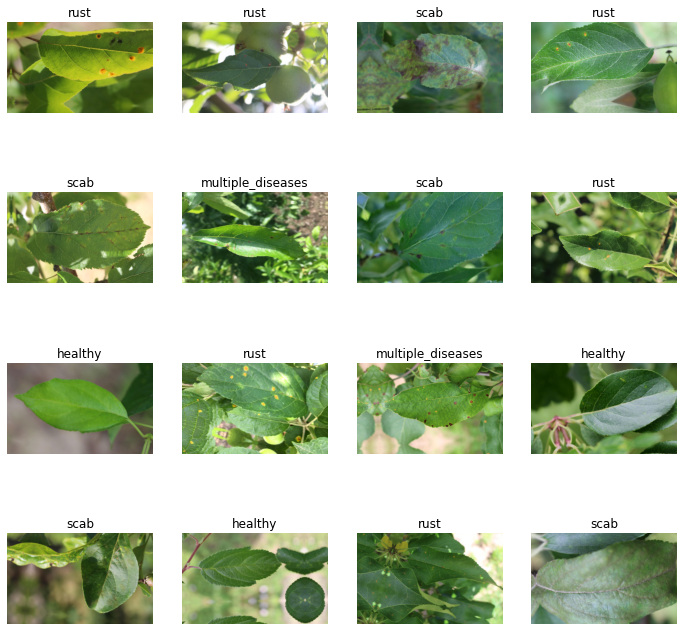

In [73]:
dls = ImageDataLoaders.from_df(train,bs=16,seed=2020,item_tfms=item_tfms, batch_tfms=batch_tfms,label_col=5)
dls.show_batch(max_n=16)

# Loss Function

The codebase I am working off of uses Cross Entropy Loss on one-hot encoded values and I will as well.  The one hot encoding will be important later for soft labeling.  Using pure pytorch is completely compatible with fastai and we can pass this directly to our learner no problem.

In [9]:
class CrossEntropyLossOneHot(nn.Module):
    def __init__(self):
        super(CrossEntropyLossOneHot, self).__init__()
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, preds, labels):
        return torch.mean(torch.sum(-labels * self.log_softmax(preds), -1))

# Optimizer & Scheduler

In the original code base they had to write an Optimizer and Scheduler themselves in pytorch for use in pytorch lightning, but we can skip this.  The approach they used is the approach fastai uses by default.  It's a good example of fastai having SoTA defaults that saves time without sacrificing results.

![](my_icons/fitonecycledoc.png)

# Model

I will use the winning solution's `se_resnext50_32x4d` architecture.  Again, pure pytorch is just fine with fastai if you want to do custom stuff - so we don't need to modify anything from the winner's model code to make it work with fastai.  I am going to go ahead and use the same architecture they used and port is straight into the fastai learner.  A fastai model IS a pytorch model - so there's no problem with this.

In [10]:
import pretrainedmodels

def l2_norm(input, axis=1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output


class BinaryHead(nn.Module):
    def __init__(self, num_class=4, emb_size=2048, s=16.0):
        super(BinaryHead, self).__init__()
        self.s = s
        self.fc = nn.Sequential(nn.Linear(emb_size, num_class))

    def forward(self, fea):
        fea = l2_norm(fea)
        logit = self.fc(fea) * self.s
        return logit


class se_resnext50_32x4d(nn.Module):
    def __init__(self):
        super(se_resnext50_32x4d, self).__init__()

        self.model_ft = nn.Sequential(
            *list(pretrainedmodels.__dict__["se_resnext50_32x4d"](num_classes=1000, pretrained="imagenet").children())[
                :-2
            ]
        )
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.model_ft.last_linear = None
        self.fea_bn = nn.BatchNorm1d(2048)
        self.fea_bn.bias.requires_grad_(False)
        self.binary_head = BinaryHead(4, emb_size=2048, s=1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):

        img_feature = self.model_ft(x)
        img_feature = self.avg_pool(img_feature)
        img_feature = img_feature.view(img_feature.size(0), -1)
        fea = self.fea_bn(img_feature)
        # fea = self.dropout(fea)
        output = self.binary_head(fea)

        return output

# Soft Label Callback

Now, I write a callback to grab the one-hot encoded labels instead of the encoded column in our training loop.  This won't do anything until we have our distiilled labels, but I will set the model up this way now so I don't have to modify anything later

In [11]:
class SoftLabelCB(Callback):
    
    def before_train(self):
        self.imgs_list = L(o for o in self.dl.items.iloc[:,0].values) # get list of images in the order they are drawn this epoch
        self.df = self.dl.items.set_index('image_id')
    
    def before_validate(self):
        self.imgs_list = L(o for o in self.dl.items.iloc[:,0].values) # get list of images in the order they are drawn this epoch
        self.df = self.dl.items.set_index('image_id')

    def before_batch(self):
        df = self.df
        imgs = self.imgs_list[self.dl._DataLoader__idxs[self.iter*self.dl.bs:self.iter*self.dl.bs+self.dl.bs]]
        one_hot_yb = df.loc[imgs,df.columns[:-1]].values
        self.learn.yb = (Tensor(one_hot_yb).cuda(),)

When I train I will be doing folds to generate new labels for the training set for knowledge distillation.  I might as well set up inference and make predictions for each of the folds.  I'm also adding 4 fold TTA - it's no effort for me to do it in fastai (`learn.get_preds` vs `learn.tta`.)

# Inference

In [12]:
def test_predict(cnt,msg):
    # Create Test Dataloaders
    test = process_df('data/sample_submission.csv')
    test_dl = dls.test_dl(test) 

    # predict with test time augmentation
    preds, _ = learn.tta(dl=test_dl) 
    p = preds.softmax(axis=1) 

    # format submission file
    test = pd.read_csv('data/sample_submission.csv')['image_id']
    out_a = pd.concat([test,pd.DataFrame(p,columns = learn.dls.vocab)],axis=1)[['image_id','healthy','multiple_diseases','rust','scab']]

    # write to csv and submit to kaggle
    out_a.to_csv(f'submission{cnt}.csv',index=False)
    os.system(f'''kaggle competitions submit -c plant-pathology-2020-fgvc7 -f submission{cnt}.csv -m "{msg}"''')

# Training

That's all I need for the model.  Here's what's going on:

+ I am doing a stratified k fold instead of a normal k fold
+ In the learner I pass in all the stuff defined above, some of which was fastai stuff and others from pytorch.  Super easy to mix and match as needed.
    + dataloaders (dls) that was defined using the fastai api
    + Model that was defined using pretrainedmodels and pytorch
    + Loss function that is pytorch
    + Callbacks for gradient clipping as well as what will be soft labeling (for now it just uses the one hot encoded labels)
    + to_fp16 does the half precision for me
+ fine_tune takes care of the training for me.  Ill go with the default freeze_epochs, learning rate, optimizer, and scheduler.
+ Instead of generating a normal predictions, I am doing a 4 count tta.  As you can see, it's very easy to do.

Lets pass the data (dls) the model (se_resnext50_32x4d), the loss function (CrossEntropyLossOneHot), the cbs (GradientClip and SoftLabelCB), and convert that to fp16.  This will generate our distilled labels, which is just predictions on the training set.

>Note: I am skipping picking a learning rate.  Fastai's default is pretty good most of the time and is plenty good to demonstrate top tier results in this instance for the blog post, but the lr_find in fastai is reccomended to find an appropriate learning rate when you are looking for the best results possible.

I am also not going to do early stopping like in the winning solution.  If the model overfits I would rather retrain from scratch with fewer epochs due to the nature of cyclic learning rates.  That said you can add the `EarlyStoppingCallback` in about 2 seconds if you want to.  [Here's the docs for it ](https://docs.fast.ai/callback.tracker.html#EarlyStoppingCallback)

## Getting Distilled (soft) labels

Here's the 5 fold to get predictions on our entire training set.

In [13]:
# #hide_output
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
splits, preds, targs, preds_c,  = [],[],[],[]

true = pd.DataFrame(columns = L(o for o in train.columns))
pred = pd.DataFrame(columns = L(o for o in train.columns))
i=0
for _, val_idx in skf.split(train.image_id,train.label):
    splitter = IndexSplitter(val_idx)

    # Create dataloaders splittin on indexes defined by StratifiedKFold
    db = DataBlock(blocks=(ImageBlock,CategoryBlock),
                    get_x=ColReader(0),get_y=ColReader(5),
                    item_tfms=item_tfms,batch_tfms=batch_tfms,
                    splitter=splitter)
    dls = db.dataloaders(train,bs=24)

    #train model with fastai dataloaders, pytorch model, pytorch loss function, fastai gradient clipping, custom callback, on fp16 precision 
    learn = Learner(dls,se_resnext50_32x4d(),loss_func=CrossEntropyLossOneHot(),cbs=[GradientClip,SoftLabelCB()]).to_fp16()
    learn.fine_tune(80,reset_opt=True) # Train freeze epoch then unfreeze for 80 epochs   

    p, _ = learn.tta() # test time augmentation
    p=p.softmax(axis=1) # Convert to probabilities

    # Format dataframe to save
    items_pred=pd.DataFrame(p,columns=dls.vocab)
    items_pred['label'] = [dls.vocab[int(o)] for o in p.argmax(dim=1)]
    items_pred['image_id'] = dls.valid.items.image_id.values
    items_pred = items_pred[train.columns]
    true = pd.concat([true,dls.valid.items])
    pred = pd.concat([pred,items_pred])

    # predict and submit to kaggle
    test_predict(i,f'distilling labels fold count {i}') 
    i+=1

In [14]:
pred.to_csv('distilled_labels.csv',index=False)

Great!  So that got us to third place with the best model already!  Here's the fold scores.  Our second place model as well as an average of all 5 fold predictions were both also in the top 10.  We successfully got into the top 10 already with 3 submissions.  It is also helpful to note that the most reasonable 2 models to pick would be the average of all 5 fold predictions as well as the 3rd place submission based on the public leaderboard (as when choosing which to use in an active competition you wouldn't be able to see the private leaderboard score).  Mission accomplished!

First place in the competition had a Private Leaderboard score of 0.98445 with 10th place had 0.97883 for reference.  

As you can see, fastai is plenty capable to compete on the cutting edge at the top of kaggle competitions.

![](my_icons/First5Fold.png)

## Training with Soft Labeling

I am not going to go through the rest of the implementation, but the key technique in the rest is soft labeling.  Since this is not a super commonly known technique I am going to explain how to do it in fastai.  

Soft labeling is taking a weighted average of a predicted label and a truth label and training your model on that.  This tends to be a good thing to try when some of your labels are wrong.  Generally labels that the model get wrong are more likely to be the mislabeled ones, and so when you take a weighted average those get label smoothing applies which makes your model react less to those outliers.

So how to do it within fastai?  Well we already had the callback set up that allows our model to take one hot encoded labels, so all we need to do is set the weights in our dataframe and re-run what we did before.  At this point the fastai implementation is done (the callback), and all I need to do is pass it the soft labeled values as the targets instead of the one hot encoded I was using before.

To demonstrate:

+ Load training labels and datat

In [61]:
train = process_df('data/train.csv')
train = train.sort_values('image_id')

+ Load predictions from previous k-fold

In [62]:
distilled_labels = pd.read_csv('distilled_labels.csv')
distilled_labels = distilled_labels.sort_values('image_id');

# Get one hot encoded labels (zeros and ones)
distilled_labels.iloc[:,1:-1] = pd.get_dummies(distilled_labels.label)

+ Weight as you see fit (winner did 7:3 ratio)

In [63]:
# check to make sure the data matches
assert (train.image_id.values==distilled_labels.image_id.values).all()
distilled_labels.reset_index(drop=True,inplace=True); train.reset_index(drop=True,inplace=True); 

# get soft labels
train.iloc[:,1:-1] = distilled_labels.iloc[:,1:-1] * .3 + train.iloc[:,1:-1] * .7
train.loc[train.healthy == 0.3][:5]

,image_id,healthy,multiple_diseases,rust,scab,label
33,data/images/Train_1027.jpg,0.3,0.0,0.0,0.7,scab
47,data/images/Train_104.jpg,0.3,0.7,0.0,0.0,multiple_diseases
146,data/images/Train_1129.jpg,0.3,0.7,0.0,0.0,multiple_diseases
392,data/images/Train_1350.jpg,0.3,0.0,0.0,0.7,scab
574,data/images/Train_1514.jpg,0.3,0.7,0.0,0.0,multiple_diseases


In [64]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,data/images/Train_0.jpg,0.0,0.0,0.0,1.0,scab
1,data/images/Train_1.jpg,0.0,1.0,0.0,0.0,multiple_diseases
2,data/images/Train_10.jpg,0.0,0.0,1.0,0.0,rust
3,data/images/Train_100.jpg,1.0,0.0,0.0,0.0,healthy
4,data/images/Train_1000.jpg,0.0,0.0,1.0,0.0,rust


Great - that's exactly what we want.  We were already using the SoftLabelCB above - so that's it.  You can rerun the same kfold code above or train a single model.  Feel free to check out the repository linked above to see the exact implementation and details if you want to do a recreation of their results and the rest of their solution!

Just remember If you got the results you are looking for in a significantly easier way than you have thought - This is a good thing and a testament to the power of the library (fastai).  This not an indication that you are using a beginner tool.  Fastai takes care of all the normal SoTA best practices for you so you can focus on bleeding edge implementations or problem specific challenges.  Sometimes that means when you go to implement something or work a problem it "just works" with lot less effort than you were expecting and you are left thinking "That's it?".  How could that possibly be a reasonable reason not to use the library or to think it's not an effective library?

> twitter: https://twitter.com/BBrainkite/status/1359192051837984778